# Training and evaluation of multiple machine learning models on HDMA data for loan approval

#### First, we need to import the necessary libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb
import seaborn as sns
import itertools

warnings.filterwarnings('ignore')

#### Part 1: loading in the data and preparing it for use for our models

In [26]:
def load_and_prepare_data(main_file: str, panel_file: str, ts_file: str, sample_size: int = 500000) -> Tuple[pd.DataFrame, Dict]:
    """
    Load and prepare the HMDA dataset using chunked processing and sampling.
    Returns processed dataframe and data statistics dictionary.

    Args:
        main_file (str): Path to the main HMDA data file.
        panel_file (str): Path to the panel data file.
        ts_file (str): Path to the transmittal data file.
        sample_size (int): Number of records to sample from the main file. Default is 500,000.

    Returns:
        Tuple[pd.DataFrame, Dict]: Processed dataframe and data statistics dictionary.
    """
    # Define only the columns we need
    needed_columns = [
        'action_taken',
        'loan_amount_000s',
        'applicant_income_000s',
        'applicant_race_name_1',
        'applicant_ethnicity',
        'applicant_sex',
        'hud_median_family_income',
        'denial_reason_1',
        'state_code',
        'county_code',
        'minority_population',
        'tract_to_msamd_income'
    ]
    
    print("Loading and sampling main HMDA data...")
    
    # Initialize empty list to store chunks
    chunks = []
    # Define chunk size based on what computer can handle
    chunk_size = 100000
    
    # Read the file in chunks - helps with memory issues
    for chunk in pd.read_csv(main_file, 
                           usecols=needed_columns,
                           chunksize=chunk_size):
        # Sample from each chunk proportionally
        chunk_sample_size = int(sample_size * (chunk_size / 14285496))  # Total records from 2017 HMDA data
        sampled_chunk = chunk.sample(n=min(chunk_sample_size, len(chunk)))
        chunks.append(sampled_chunk)
        
        # Print progress
        print(f"Processed chunk, current sample size: {sum(len(chunk) for chunk in chunks)}")
        
        # Stop if we have enough samples
        if sum(len(chunk) for chunk in chunks) >= sample_size:
            break
    
    # Combine chunks
    df = pd.concat(chunks, ignore_index=True)
    print(f"Final sample size: {len(df)}")
    
    # Basic data cleaning
    print("Performing initial data cleaning...")
    
    # Convert action_taken to binary (approved = 1, denied = 0)
    df['approved'] = df['action_taken'].isin([1, 2]).astype(int)
    
    # Calculate approval rates by different demographics
    stats = {}
    
    # Overall approval rate
    stats['overall_approval_rate'] = df['approved'].mean()
    
    # Approval rates by race (using primary race)
    race_approvals = df.groupby('applicant_race_name_1')['approved'].agg(['mean', 'count'])
    stats['race_approval_rates'] = race_approvals
    
    # Approval rates by income bracket
    df['income_bracket'] = pd.qcut(df['applicant_income_000s'].fillna(-1), 
                                 q=5, 
                                 labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    income_approvals = df.groupby('income_bracket')['approved'].agg(['mean', 'count'])
    stats['income_approval_rates'] = income_approvals
    
    # Calculate loan amount approval rates
    # Create loan amount bins
    df['loan_bin'] = pd.qcut(df['loan_amount_000s'].dropna(), q=10, labels=False)
    loan_approval_rates = df.groupby('loan_bin')['approved'].mean()
    stats['loan_amount_approval_rates'] = loan_approval_rates.tolist()
    
    print("\nBasic dataset statistics:")
    print(f"Number of applications: {len(df):,}")
    print(f"Number of approved loans: {df['approved'].sum():,}")
    print(f"Overall approval rate: {df['approved'].mean():.2%}")
    
    return df, stats

def generate_exploratory_plots(df: pd.DataFrame, stats: Dict) -> None:
    """
    Generate exploratory plots to visualize key patterns in the data.

    Args:
        df (pd.DataFrame): Processed HMDA dataset. Output from load_and_prepare_data().
        stats (Dict): Data statistics dictionary. Output from load_and_prepare_data().

    Returns:
        None
    """
    plt.figure(figsize=(20, 15))
    
    # 1. Approval Rates by Race
    plt.subplot(2, 2, 1)
    approval_by_race = stats['race_approval_rates']['mean'].sort_values()
    plt.bar(range(len(approval_by_race)), approval_by_race.values)
    plt.title('Approval Rates by Race')
    plt.xticks(range(len(approval_by_race)), 
              approval_by_race.index, 
              rotation=45, 
              ha='right')
    plt.ylabel('Approval Rate')
    
    # 2. Approval Rates by Income Bracket
    plt.subplot(2, 2, 2)
    income_approval = stats['income_approval_rates']['mean']
    plt.bar(range(len(income_approval)), income_approval.values)
    plt.title('Approval Rates by Income Bracket')
    plt.xticks(range(len(income_approval)), 
               income_approval.index,
               rotation=45)
    plt.ylabel('Approval Rate')
    
    # 3. Distribution of Loan Amounts
    plt.subplot(2, 2, 3)
    plt.hist(df['loan_amount_000s'].dropna(), bins=50)
    plt.title('Distribution of Loan Amounts')
    plt.xlabel('Loan Amount (thousands)')
    
    # 4. Approval Rate by Loan Amount
    plt.subplot(2, 2, 4)
    plt.plot(range(10), stats['loan_amount_approval_rates'], marker='o')
    plt.title('Approval Rate by Loan Amount')
    plt.xlabel('Loan Amount Decile (0=Lowest, 9=Highest)')
    plt.ylabel('Approval Rate')
    
    plt.tight_layout()
    plt.show()

def preprocess_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
    """
    Preprocess the HMDA dataset and create feature groups for analysis.
    Returns preprocessed dataframe and dictionary of feature groups.

    Args:
        df (pd.DataFrame): Processed HMDA dataset. Output from load_and_prepare_data().

    Returns:
        Tuple[pd.DataFrame, Dict[str, List[str]]]: Preprocessed dataframe and feature groups dictionary.
    """
    print("Starting data preprocessing...")
    
    # Create copy to avoid modifying original data
    data = df.copy()
    
    # Remove rows where action_taken is not 1, 2, or 3 
    # (so, remove the withdrawn/incomplete applications)
    data = data[data['action_taken'].isin([1, 2, 3])]
    
    # Define feature groups based on available columns
    feature_groups = {
        'baseline': [
            'loan_amount_000s',
            'applicant_income_000s',
            'hud_median_family_income',
            'tract_to_msamd_income',
            'income_to_loan_ratio',  # Will be created
            'area_income_ratio'      # Will be created
        ],
        
        'location': [
            'state_code',
            'county_code',
            'minority_population'
        ],
        
        'sensitive': [
            'applicant_race_name_1',
            'applicant_ethnicity',
            'applicant_sex'
        ]
    }
    
    # Handle missing values
    print("Handling missing values...")
    
    # Numeric columns: fill with median
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_columns:
        data[col] = data[col].fillna(data[col].median())
    
    # Categorical columns: fill with mode
    categorical_columns = data.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        data[col] = data[col].fillna(data[col].mode()[0])
    
    # Create derived features
    print("Creating derived features...")
    
    # Income to loan ratio
    data['income_to_loan_ratio'] = (data['applicant_income_000s'] / 
                                   data['loan_amount_000s']).replace([np.inf, -np.inf], np.nan)
    data['income_to_loan_ratio'] = data['income_to_loan_ratio'].fillna(
        data['income_to_loan_ratio'].median())
    
    # Area income ratio
    data['area_income_ratio'] = (data['applicant_income_000s'] / 
                                data['hud_median_family_income']).replace([np.inf, -np.inf], np.nan)
    data['area_income_ratio'] = data['area_income_ratio'].fillna(
        data['area_income_ratio'].median())
    
    return data, feature_groups

def create_model_datasets(data: pd.DataFrame, 
                        feature_groups: Dict[str, List[str]], 
                        test_size: float = 0.2,
                        random_state: int = 42) -> Dict[str, Tuple]:
    """
    Create different datasets for model training with different feature combinations.
    Returns dictionary with various train-test splits.

    Args:
        data (pd.DataFrame): Preprocessed HMDA dataset. Output from preprocess_data().
        feature_groups (Dict[str, List[str]]): Dictionary of feature groups. Output from preprocess_data().
        test_size (float): Test size for train-test split. Default is 0.2.
        random_state (int): Random seed for train-test split. Default is 42.

    Returns:
        Dict[str, Tuple]: Dictionary of datasets for different feature combinations.
    """
    print("Creating model datasets...")
    
    datasets = {}
    
    # Create label encoder for categorical variables
    le = LabelEncoder()
    
    # 1. Baseline dataset (no sensitive features)
    X_baseline = data[feature_groups['baseline']].copy()
    
    # Handle categorical variables in baseline features
    categorical_baseline = X_baseline.select_dtypes(include=['object']).columns
    for col in categorical_baseline:
        X_baseline[col] = le.fit_transform(X_baseline[col])
    
    # Create target variable
    y = data['approved']
    
    # Create train-test split for baseline
    X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
        X_baseline, y, test_size=test_size, random_state=random_state
    )
    datasets['baseline'] = (X_train_base, X_test_base, y_train_base, y_test_base)
    
    # 2. Dataset with location features
    X_with_location = pd.concat([
        X_baseline,
        data[feature_groups['location']]
    ], axis=1)
    
    categorical_loc = X_with_location.select_dtypes(include=['object']).columns
    for col in categorical_loc:
        X_with_location[col] = le.fit_transform(X_with_location[col])
    
    X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(
        X_with_location, y, test_size=test_size, random_state=random_state
    )
    datasets['with_location'] = (X_train_loc, X_test_loc, y_train_loc, y_test_loc)
    
    # 3. Dataset with all features including sensitive ones
    X_all = pd.concat([
        X_baseline,
        data[feature_groups['location']],
        data[feature_groups['sensitive']]
    ], axis=1)
    
    categorical_all = X_all.select_dtypes(include=['object']).columns
    for col in categorical_all:
        X_all[col] = le.fit_transform(X_all[col])
    
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
        X_all, y, test_size=test_size, random_state=random_state
    )
    datasets['all_features'] = (X_train_all, X_test_all, y_train_all, y_test_all)
    
    print("\nCreated datasets with shapes:")
    for name, (X_train, X_test, y_train, y_test) in datasets.items():
        print(f"{name}:")
        print(f"  Training: {X_train.shape}")
        print(f"  Testing:  {X_test.shape}")
    
    return datasets

def prepare_scalers(datasets: Dict[str, Tuple]) -> Dict[str, StandardScaler]:
    """
    Create and fit scalers for each dataset. The purpose is to standardize the data.

    Args:
        datasets (Dict[str, Tuple]): Dictionary of datasets. Output from create_model_datasets().
    Returns:
        Dict[str, StandardScaler]: Dictionary of fitted scalers.
    """
    print("\nPreparing scalers...")
    
    scalers = {}
    for name, (X_train, _, _, _) in datasets.items():
        scaler = StandardScaler()
        scaler.fit(X_train)
        scalers[name] = scaler
    
    return scalers

#### Part 2: defining functions to train and evaluate our baseline models (logistic regression, random forest, XGboost)

In [27]:
def train_models(datasets: Dict[str, Tuple], scalers: Dict[str, StandardScaler]) -> Dict:
    """
    Train multiple models on different feature sets and return the trained models.

    Args:
        datasets (Dict[str, Tuple]): Dictionary of datasets. Output from create_model_datasets().
        scalers (Dict[str, StandardScaler]): Dictionary of fitted scalers. Output from prepare_scalers().

    Returns:
        Dict: Dictionary of trained models.
    """
    print("Training models...")
    models = {}
    
    # Model configurations
    model_configs = {
        'random_forest': {
            'model': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'name': 'Random Forest'
        },
        'logistic': {
            'model': LogisticRegression(random_state=42, max_iter=1000),
            'name': 'Logistic Regression'
        },
        'xgboost': {
            'model': xgb.XGBClassifier(random_state=42, n_jobs=-1),
            'name': 'XGBoost'
        }
    }
    
    # Train models for each dataset
    for dataset_name, (X_train, X_test, y_train, y_test) in datasets.items():
        models[dataset_name] = {}
        
        # Scale the features
        X_train_scaled = scalers[dataset_name].transform(X_train)
        X_test_scaled = scalers[dataset_name].transform(X_test)
        
        # Train each model type
        for model_name, config in model_configs.items():
            print(f"Training {config['name']} on {dataset_name} dataset...")
            model = config['model']
            model.fit(X_train_scaled, y_train)
            
            # Store model and predictions
            models[dataset_name][model_name] = {
                'model': model,
                'predictions': model.predict(X_test_scaled),
                'probabilities': model.predict_proba(X_test_scaled)[:, 1],
                'feature_names': X_train.columns.tolist()
            }
    
    return models

def evaluate_models(models: Dict, datasets: Dict) -> pd.DataFrame:
    """
    Evaluate models and return performance metrics.

    Args:
        models (Dict): Dictionary of trained models. Output from train_models().
        datasets (Dict): Dictionary of datasets. Output from create_model_datasets().

    Returns:
        pd.DataFrame: DataFrame with model performance metrics.
    """
    print("\nEvaluating model performance...")
    results = []
    
    for dataset_name, model_dict in models.items():
        _, _, _, y_test = datasets[dataset_name]
        
        for model_name, model_info in model_dict.items():
            predictions = model_info['predictions']
            probabilities = model_info['probabilities']
            
            # Calculate metrics
            results.append({
                'Dataset': dataset_name,
                'Model': model_name,
                'Accuracy': accuracy_score(y_test, predictions),
                'Precision': precision_score(y_test, predictions),
                'Recall': recall_score(y_test, predictions),
                'F1': f1_score(y_test, predictions),
                'AUC-ROC': roc_auc_score(y_test, probabilities)
            })
    
    # Create DataFrame from results
    return pd.DataFrame(results)

#### Part 3: analyzing bias and creating plots for model performance and bias

In [91]:
def analyze_bias(models: Dict, data: pd.DataFrame, datasets: Dict) -> Dict:
    """
    Analyze bias in model predictions across different demographic groups.

    Args:
        models (Dict): Dictionary of trained models. Output from train_models().
        data (pd.DataFrame): Preprocessed HMDA dataset. Output from preprocess_data().
        datasets (Dict): Dictionary of datasets. Output from create_model_datasets().

    Returns:
        Dict: Dictionary of bias metrics.
    """
    print("\nAnalyzing model bias...")
    bias_metrics = {}
    
    # Get test data and indices
    for dataset_name, model_dict in models.items():
        _, test_data, _, _ = datasets[dataset_name]
        test_indices = test_data.index
        
        # Get the race information for test set only
        test_races = data.loc[test_indices, 'applicant_race_name_1']
        
        for model_name, model_info in model_dict.items():
            key = f"{dataset_name}_{model_name}"
            bias_metrics[key] = {}
            
            # Get predictions for this model
            predictions = model_info['predictions']
            
            # Create DataFrame with race and predictions
            bias_df = pd.DataFrame({
                'applicant_race_name_1': test_races,
                'predicted_approval': predictions
            })
            
            # Analyze predicted approval rates by race
            race_bias = bias_df.groupby('applicant_race_name_1').agg({
                'predicted_approval': 'mean'
            }).reset_index()
            
            # Rename column to match original format
            race_bias = race_bias.rename(columns={'predicted_approval': 'approved'})
            
            # Calculate approval rate disparities
            overall_approval = predictions.mean()
            race_bias['disparity'] = race_bias['approved'] - overall_approval
            
            bias_metrics[key]['race_bias'] = race_bias
            
            # Print progress
            print(f"\nBias metrics for {key}:")
            print(race_bias)
    
    return bias_metrics

def plot_results(evaluation_results: pd.DataFrame, bias_metrics: Dict):
    """
    Create visualizations for model performance and bias analysis.

    Args:
        evaluation_results (pd.DataFrame): DataFrame with model performance metrics. Output from evaluate_models().
        bias_metrics (Dict): Dictionary of bias metrics. Output from analyze_bias().

    Returns:
        None
    """
    # Plot 1: Model Performance Comparison
    plt.figure(figsize=(15, 6))
    
    # Create grouped bar plot for accuracy
    sns.barplot(data=evaluation_results, x='Model', y='Accuracy', hue='Dataset')
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.ylim(0.7, 0.85)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Bias Analysis
    plt.figure(figsize=(15, 6))
    
    # Mapping for race labels
    race_mapping = {
        "American Indian or Alaska Native": "American Indian",
        "Asian": "Asian",
        "Black or African American": "African American",
        "Native Hawaiian or Other Pacific Islander": "Pacific Islander",
        "White": "White",
    }

    # Select a specific model for bias visualization
    model_key = 'all_features_xgboost'
    race_bias = bias_metrics[model_key]['race_bias']

    # Map race names and filter out undesired rows
    race_bias['applicant_race_name_1'] = race_bias['applicant_race_name_1'].map(race_mapping)
    race_bias = race_bias.dropna(subset=['applicant_race_name_1'])  # Remove any rows that were not mapped

    # Create horizontal bar plot for disparity by race
    plt.barh(race_bias['applicant_race_name_1'], race_bias['disparity'])
    plt.title(f'Approval Rate Disparity by Race\n({model_key})')
    plt.xlabel('Difference from Overall Approval Rate')
    plt.ylabel('Race')
    plt.tight_layout()
    plt.show()


#### Part 4: Looking into the importance/effect of specific features in the data on model performance

In [98]:
def analyze_feature_importance(models: Dict):
    """
    Analyze and visualize feature importance for tree-based models.

    Args:
        models (Dict): Dictionary of trained models. Output from train_models().

    Returns:
        None
    """
    print("\nAnalyzing feature importance...")
    
    for dataset_name, model_dict in models.items():
        # Handle Random Forest
        if 'random_forest' in model_dict:
            rf_info = model_dict['random_forest']
            rf_model = rf_info['model']
            rf_features = rf_info['feature_names']
            
            if len(rf_features) == len(rf_model.feature_importances_):
                feat_importance_rf = pd.DataFrame({
                    'feature': rf_features,
                    'importance': rf_model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                plt.figure(figsize=(10, 6))
                sns.barplot(data=feat_importance_rf, x='importance', y='feature')
                plt.title(f'Random Forest Feature Importance ({dataset_name})')
                plt.tight_layout()
                plt.show()
        
        # Handle XGBoost
        if 'xgboost' in model_dict:
            xgb_info = model_dict['xgboost']
            xgb_model = xgb_info['model']
            xgb_features = xgb_info['feature_names']
            
            if len(xgb_features) == len(xgb_model.feature_importances_):
                feat_importance_xgb = pd.DataFrame({
                    'feature': xgb_features,
                    'importance': xgb_model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                plt.figure(figsize=(10, 6))
                sns.barplot(data=feat_importance_xgb, x='importance', y='feature')
                plt.title(f'XGBoost Feature Importance ({dataset_name})')
                plt.tight_layout()
                plt.show()

def analyze_prediction_changes(models: Dict, data: pd.DataFrame, datasets: Dict) -> pd.DataFrame:
    """
    Analyze how predictions change when sensitive features are added.

    Args:
        models (Dict): Dictionary of trained models. Output from train_models().
        data (pd.DataFrame): Preprocessed HMDA dataset. Output from preprocess_data().
        datasets (Dict): Dictionary of datasets. Output from create_model_datasets().

    Returns:
        pd.DataFrame: DataFrame with prediction change analysis.
    """
    print("\nAnalyzing prediction changes between models...")
    
    # Get test data indices to align predictions with demographic data
    _, test_data, _, _ = datasets['baseline']
    test_indices = test_data.index
    
    # Get the corresponding slice of demographic data
    test_demographics = data.loc[test_indices]
    
    changes = []
    
    for model_type in ['random_forest', 'logistic', 'xgboost']:
        base_preds = models['baseline'][model_type]['predictions']
        full_preds = models['all_features'][model_type]['predictions']
        
        # Find where predictions changed
        changed_predictions = (base_preds != full_preds).sum()
        
        # Analyze changes by demographic group
        for race in test_demographics['applicant_race_name_1'].unique():
            race_mask = test_demographics['applicant_race_name_1'] == race
            race_changes = (base_preds[race_mask] != full_preds[race_mask]).sum()
            
            changes.append({
                'Model': model_type,
                'Race': race,
                'Total_Changes': race_changes,
                'Change_Rate': race_changes / sum(race_mask) if sum(race_mask) > 0 else 0
            })
    
    return pd.DataFrame(changes)

def analyze_feature_correlations(data: pd.DataFrame, feature_groups: Dict) -> None:
    """
    Analyze correlations between features and approval decisions.

    Args:
        data (pd.DataFrame): Preprocessed HMDA dataset. Output from preprocess_data().
        feature_groups (Dict): Dictionary of feature groups. Output from preprocess_data().

    Returns:
        None
    """
    print("\nAnalyzing feature correlations...")
    
    # Combine all numeric features
    numeric_features = [f for f in feature_groups['baseline'] 
                       if data[f].dtype in ['int64', 'float64']]
    numeric_features.extend([f for f in feature_groups['location'] 
                           if data[f].dtype in ['int64', 'float64']])
    
    # Add target variable
    features_to_correlate = numeric_features + ['approved']
    
    # Calculate correlations
    corr_matrix = data[features_to_correlate].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0)
    plt.title('Feature Correlations with Approval Decision')
    plt.tight_layout()
    plt.show()

def encode_categorical_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Encode categorical features for model input.

    Args:
        X (pd.DataFrame): Input features.

    Returns:
        pd.DataFrame: Encoded features
    """
    X_encoded = X.copy()
    le = LabelEncoder()
    
    # Encode categorical columns
    for column in X.columns:
        if X[column].dtype == 'object':
            X_encoded[column] = le.fit_transform(X[column])
    
    return X_encoded

def analyze_sequential_feature_addition(data: pd.DataFrame, models: Dict, scalers: Dict, feature_groups: Dict, datasets: Dict) -> None:
    """
    Analyze how adding each sensitive feature sequentially affects model predictions.

    Args:
        data (pd.DataFrame): Preprocessed HMDA dataset. Output from preprocess_data().
        models (Dict): Dictionary of trained models. Output from train_models().
        scalers (Dict): Dictionary of fitted scalers. Output from prepare_scalers().
        feature_groups (Dict): Dictionary of feature groups. Output from preprocess_data().
        datasets (Dict): Dictionary of datasets. Output from create_model_datasets().

    Returns:
        None
    """
    print("\nAnalyzing sequential feature addition...")
    
    # Get original train/test split
    X_train_base, X_test_base, y_train_base, y_test_base = datasets['baseline']
    train_indices = X_train_base.index
    test_indices = X_test_base.index
    
    # Sensitive features and their mappings
    sensitive_features = ['applicant_race_name_1', 'applicant_sex', 'applicant_ethnicity']
    feature_mappings = {
        'applicant_race_name_1': 'race',
        'applicant_sex': 'sex',
        'applicant_ethnicity': 'ethnicity'
    }
    
    feature_combinations = []
    
    # Create all combinations of sensitive features
    for i in range(len(sensitive_features)):
        for combo in itertools.combinations(sensitive_features, i+1):
            feature_combinations.append(list(combo))
    
    results = []
    baseline_predictions = {}
    
    # Get baseline predictions for each model
    for model_name, model_info in models['baseline'].items():
        baseline_predictions[model_name] = model_info['predictions']
    
    # Train models with different feature combinations
    for features in feature_combinations:
        print(f"\nTesting feature combination: {', '.join(features)}")
        
        # Combine baseline features with current sensitive features
        feature_set = feature_groups['baseline'] + features
        
        # Get data using original train/test splits
        X = data[feature_set]
        X_encoded = encode_categorical_features(X)
        
        X_train = X_encoded.loc[train_indices]
        X_test = X_encoded.loc[test_indices]
        y_train = data.loc[train_indices, 'approved']
        y_test = data.loc[test_indices, 'approved']
        
        # Scale features using same approach as original models
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        for model_name, model_info in models['baseline'].items():
            print(f"Training {model_name}...")
            
            # Create fresh instance of the same model type
            if model_name == 'random_forest':
                model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            elif model_name == 'logistic':
                model = LogisticRegression(random_state=42, max_iter=1000)
            elif model_name == 'xgboost':
                model = xgb.XGBClassifier(random_state=42, n_jobs=-1)
            
            # Train and predict
            model.fit(X_train_scaled, y_train)
            new_predictions = model.predict(X_test_scaled)
            
            # Calculate changes from baseline
            base_preds = baseline_predictions[model_name]
            changes = (new_predictions != base_preds).mean()
            
            # Map features to their new labels
            mapped_features = [feature_mappings[feature] for feature in features]
            results.append({
                'Model': model_name,
                'Features_Added': '+'.join(mapped_features),
                'Prediction_Changes': changes,
                'Accuracy': accuracy_score(y_test, new_predictions),
                'Base_Accuracy': accuracy_score(y_test, base_preds),
                'Accuracy_Delta': accuracy_score(y_test, new_predictions) - accuracy_score(y_test, base_preds)
            })
    
    # Create separate visualizations
    df_results = pd.DataFrame(results)

    # Plot 1: Prediction Changes
    plt.figure(figsize=(15, 6))
    sns.barplot(data=df_results, 
                x='Features_Added', y='Prediction_Changes', 
                hue='Model')
    plt.title('Prediction Changes by Feature Addition')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Accuracy Delta (Change in Accuracy)
    plt.figure(figsize=(15, 6))
    sns.barplot(data=df_results, 
                x='Features_Added', y='Accuracy_Delta', 
                hue='Model')
    plt.title('Change in Accuracy from Baseline')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nDetailed Results:")
    print(df_results[['Model', 'Features_Added', 'Prediction_Changes', 
                     'Base_Accuracy', 'Accuracy', 'Accuracy_Delta']].to_string())

#### Part 5: Looking into model fairness and demographics analysis

In [99]:
def calculate_fair_metrics(models: Dict, data: pd.DataFrame, datasets: Dict) -> pd.DataFrame:
    """
    Calculate fairness metrics for each model.

    Args:
        models (Dict): Dictionary of trained models. Output from train_models().
        data (pd.DataFrame): Preprocessed HMDA dataset. Output from preprocess_data().
        datasets (Dict): Dictionary of datasets. Output from create_model_datasets().

    Returns:
        pd.DataFrame: DataFrame with fairness metrics.
    """
    print("\nCalculating fairness metrics...")
    
    # Get test data indices
    _, test_data, _, _ = datasets['baseline']
    test_indices = test_data.index
    test_demographics = data.loc[test_indices]
    
    metrics = []
    privileged_group = 'White'  # Reference group
    
    for dataset_name, model_dict in models.items():
        for model_name, model_info in model_dict.items():
            predictions = model_info['predictions']
            
            # Calculate disparate impact
            priv_mask = test_demographics['applicant_race_name_1'] == privileged_group
            priv_approval_rate = predictions[priv_mask].mean()
            
            for race in test_demographics['applicant_race_name_1'].unique():
                if race != privileged_group:
                    group_mask = test_demographics['applicant_race_name_1'] == race
                    group_approval_rate = predictions[group_mask].mean()
                    
                    if priv_approval_rate > 0:  # Avoid division by zero
                        disparate_impact = group_approval_rate / priv_approval_rate
                    else:
                        disparate_impact = np.nan
                    
                    metrics.append({
                        'Dataset': dataset_name,
                        'Model': model_name,
                        'Group': race,
                        'Approval_Rate': group_approval_rate,
                        'Disparate_Impact': disparate_impact,
                        'Equal_Opportunity_Diff': group_approval_rate - priv_approval_rate
                    })
    
    return pd.DataFrame(metrics)

def plot_demographic_distribution(data: pd.DataFrame) -> None:
    """
    Visualize the distribution of approvals across demographic groups.

    Args:
        data (pd.DataFrame): Preprocessed HMDA dataset. Output from preprocess_data().

    Returns:
        None
    """
    # Mapping for race labels
    race_mapping = {
        "American Indian or Alaska Native": "American Indian",
        "Asian": "Asian",
        "Black or African American": "African American",
        "Native Hawaiian or Other Pacific Islander": "Pacific Islander",
        "White": "White",
    }

    # Filter out rows to be removed
    data = data[
        ~data["applicant_race_name_1"].isin([
            "Information not provided by applicant in mail, Internet, or telephone application",
            "Not applicable"
        ])
    ]

    # Map race names
    data["applicant_race_name_1"] = data["applicant_race_name_1"].map(race_mapping).fillna(data["applicant_race_name_1"])

    # Plot 1: Approval rates by race and income bracket
    plt.figure(figsize=(10, 6))
    approval_rates = pd.pivot_table(
        data=data,
        values='approved',
        index='applicant_race_name_1',
        columns='income_bracket',
        aggfunc='mean'
    )
    sns.heatmap(approval_rates, annot=True, fmt='.2f', cmap='YlOrRd', cbar=True)
    plt.title('Approval Rates by Race and Income')
    plt.ylabel('Race')
    plt.xlabel('Income Bracket')
    plt.show()

    # Plot 2: Distribution of loan amounts by race
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x='applicant_race_name_1', y='loan_amount_000s')
    plt.xticks(rotation=45, ha='right')
    plt.title('Loan Amount Distribution by Race')
    plt.ylabel('Loan Amount (thousands)')
    plt.xlabel('Race')
    plt.show()


def analyze_intersectional_bias(data: pd.DataFrame) -> None:
    """
    Analyze intersectional bias between different demographic features.

    Args:
        data (pd.DataFrame): Preprocessed HMDA dataset. Output from preprocess_data().

    Returns:
        None
    """
    print("\nAnalyzing intersectional bias...")

    # Mapping for race labels
    race_mapping = {
        "American Indian or Alaska Native": "American Indian",
        "Asian": "Asian",
        "Black or African American": "African American",
        "Native Hawaiian or Other Pacific Islander": "Pacific Islander",
        "White": "White",
    }

    # Filter out rows to be removed and map race names
    data = data[
        ~data["applicant_race_name_1"].isin([
            "Information not provided by applicant in mail, Internet, or telephone application",
            "Not applicable"
        ])
    ]
    data["applicant_race_name_1"] = data["applicant_race_name_1"].map(race_mapping).fillna(data["applicant_race_name_1"])

    # Mapping for sex labels
    sex_mapping = {
        1: "Male",
        2: "Female",
        3: "REMOVED",
        4: "REMOVED"
    }

    # Map and filter applicant_sex
    data["applicant_sex"] = data["applicant_sex"].map(sex_mapping)
    data = data[~data["applicant_sex"].isin(["REMOVED"])]

    plt.figure(figsize=(15, 5))
    
    # Race and Sex intersection
    plt.subplot(1, 2, 1)
    intersection_rates = pd.pivot_table(
        data=data,
        values='approved',
        index='applicant_race_name_1',
        columns='applicant_sex',
        aggfunc='mean'
    )
    sns.heatmap(intersection_rates, annot=True, fmt='.2f', cmap='RdBu', cbar=True)
    plt.title('Approval Rates by Race and Sex')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Race and Ethnicity intersection
    plt.subplot(1, 2, 2)
    intersection_rates_eth = pd.pivot_table(
        data=data,
        values='approved',
        index='applicant_race_name_1',
        columns='applicant_ethnicity',
        aggfunc='mean'
    )
    sns.heatmap(intersection_rates_eth, annot=True, fmt='.2f', cmap='RdBu', cbar=True)
    plt.title('Approval Rates by Race and Ethnicity')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print("\nIntersectional Approval Rates (Race and Sex):")
    print(intersection_rates.round(3))
    print("\nIntersectional Approval Rates (Race and Ethnicity):")
    print(intersection_rates_eth.round(3))



#### Part 6: Comparing the biases found in our ML models with the data's ground truth approval/disapproval of loans

In [112]:
def compare_human_ml_bias(data: pd.DataFrame, models: Dict, datasets: Dict) -> None:
    """
    Compare ML model biases with historical human decisions.

    Args:
        data (pd.DataFrame): Preprocessed HMDA dataset. Output from preprocess_data().
        models (Dict): Dictionary of trained models. Output from train_models().
        datasets (Dict): Dictionary of datasets. Output from create_model_datasets().

    Returns:
        None
    """
    print("\nComparing ML models with historical decisions...")
    
    # Mapping for race labels
    race_mapping = {
        "American Indian or Alaska Native": "American Indian",
        "Asian": "Asian",
        "Black or African American": "African American",
        "Native Hawaiian or Other Pacific Islander": "Pacific Islander",
        "White": "White",
    }
    
    # Get test set indices and data
    _, test_data, _, y_test = datasets['all_features']
    test_indices = test_data.index
    test_demographics = data.loc[test_indices]
    
    # Calculate historical approval rates by race
    historical_rates = data.groupby('applicant_race_name_1')['approved'].mean()

    # Map race names for historical rates
    historical_rates.index = historical_rates.index.map(race_mapping)
    historical_rates = historical_rates.dropna()  # Drop rows with unmapped races

    # Calculate ML model approval rates by race
    ml_rates = {}
    for model_name, model_info in models['all_features'].items():
        predictions = model_info['predictions']
        ml_rates[model_name] = (
            pd.DataFrame({'race': test_demographics['applicant_race_name_1'], 
                          'approved': predictions})
            .assign(race=lambda df: df['race'].map(race_mapping))
            .dropna(subset=['race'])  # Drop rows with NaN race values
            .groupby('race')['approved']
            .mean()
        )
    
    # Combine all rates into one DataFrame
    comparison_df = pd.DataFrame({'Historical': historical_rates})
    for model_name, rates in ml_rates.items():
        comparison_df[model_name] = rates
    
    # Drop rows with NaN values from the combined DataFrame
    comparison_df = comparison_df.dropna()
    
    # Calculate disparities (difference from overall mean)
    overall_historical = data['approved'].mean()
    overall_ml = {model: pred['predictions'].mean() 
                  for model, pred in models['all_features'].items()}
    
    disparity_df = pd.DataFrame({'Historical': comparison_df['Historical'] - overall_historical})
    for model in ml_rates.keys():
        disparity_df[model] = comparison_df[model] - overall_ml[model]
    
    # Plot 1: Approval Rates Comparison
    plt.figure(figsize=(15, 6))
    comparison_df.plot(kind='bar')
    plt.title('Approval Rates: Historical vs ML Models')
    plt.xlabel('Race')
    plt.ylabel('Approval Rate')
    plt.ylim(0.6, 1)  # Adjust y-axis range for approval rates
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Disparity Comparison
    plt.figure(figsize=(15, 6))
    disparity_df.plot(kind='bar')
    plt.title('Approval Rate Disparities: Historical vs ML Models')
    plt.xlabel('Race')
    plt.ylabel('Disparity (Difference from Mean)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nDetailed Approval Rates:")
    print(comparison_df.round(3))
    print("\nDetailed Disparities:")
    print(disparity_df.round(3))
    
    # Calculate bias amplification/reduction
    print("\nBias Amplification Analysis:")
    print("Amplification > 1 means model amplifies historical bias, < 1 means it reduces it")
    for model in ml_rates.keys():
        amplification = (disparity_df[model].abs() / disparity_df['Historical'].abs()).mean()
        print(f"{model} bias amplification factor: {amplification:.3f}")


#### Part 7: Load in our Neural Network predictions to compare with baseline models

In [113]:
def load_nn_predictions() -> Tuple[np.ndarray, np.ndarray]:
    """
    Load and align neural network predictions with other models' test sets. Loads
    predictions for NN models trained with and without race information.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Predictions for models
    """
    print("\nLoading Neural Network predictions...")
    
    # Load predictions
    nn_preds_no_race = np.load('nn_predictions_no_race.npy')
    nn_preds_with_race = np.load('nn_predictions_with_race.npy')
    nn_test_indices = np.load('nn_test_indices.npy')
    
    print(f"Loaded predictions - No Race: {len(nn_preds_no_race)}, With Race: {len(nn_preds_with_race)}")
    
    return nn_preds_no_race, nn_preds_with_race

#### Consolidate much of the above analysis to compare models with one another

In [114]:
def compare_all_models(traditional_models: Dict, nn_preds_no_race: np.ndarray, nn_preds_with_race: np.ndarray, 
                      data: pd.DataFrame, datasets: Dict) -> None:
    """
    Compare all models including Neural Networks

    Args:
        traditional_models (Dict): Dictionary of trained traditional models. Output from train_models().
        nn_preds_no_race (np.ndarray): Neural Network predictions without race information.
        nn_preds_with_race (np.ndarray): Neural Network predictions with race information.
        data (pd.DataFrame): Preprocessed HMDA dataset. Output from preprocess_data().
        datasets (Dict): Dictionary of datasets. Output from create_model_datasets().

    Returns:
        None
    """
    print("\nComparing all model architectures...")
    
    # Get test data
    _, test_data, _, y_test = datasets['baseline']
    test_size = len(y_test)
    
    # Trim all predictions to the same size
    min_size = min(test_size, len(nn_preds_no_race), len(nn_preds_with_race))
    print(f"Using first {min_size} samples for comparison")
    
    # Initialize results dictionary with trimmed predictions
    results = {
        'Traditional Models': {
            'Random Forest (No Race)': traditional_models['baseline']['random_forest']['predictions'][:min_size],
            'Random Forest (With Race)': traditional_models['all_features']['random_forest']['predictions'][:min_size],
            'XGBoost (No Race)': traditional_models['baseline']['xgboost']['predictions'][:min_size],
            'XGBoost (With Race)': traditional_models['all_features']['xgboost']['predictions'][:min_size],
            'Logistic (No Race)': traditional_models['baseline']['logistic']['predictions'][:min_size],
            'Logistic (With Race)': traditional_models['all_features']['logistic']['predictions'][:min_size]
        },
        'Neural Networks': {
            'NN (No Race)': nn_preds_no_race[:min_size],
            'NN (With Race)': nn_preds_with_race[:min_size]
        }
    }
    
    # Use trimmed test set
    y_test_trimmed = y_test[:min_size]
    
    # Calculate metrics for all models
    metrics_df = []
    for category, category_models in results.items():
        for model_name, predictions in category_models.items():
            metrics_df.append({
                'Category': category,
                'Model': model_name,
                'Accuracy': accuracy_score(y_test_trimmed, predictions),
                'Precision': precision_score(y_test_trimmed, predictions),
                'Recall': recall_score(y_test_trimmed, predictions),
                'F1': f1_score(y_test_trimmed, predictions)
            })
    
    metrics_df = pd.DataFrame(metrics_df)
    
    # Visualization
    # Plot 1: Accuracy Comparison
    plt.figure(figsize=(15, 6))
    sns.barplot(data=metrics_df, x='Model', y='Accuracy', hue='Category')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0.7, 0.85)  # Adjust y-axis range for accuracy
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot 2: F1 Score Comparison
    plt.figure(figsize=(15, 6))
    sns.barplot(data=metrics_df, x='Model', y='F1', hue='Category')
    plt.title('Model F1 Score Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("\nDetailed Model Comparison:")
    print(metrics_df.to_string())
    
    # Analyze race impact
    print("\nImpact of Race Feature:")
    for category, category_models in results.items():
        no_race_models = {k: v for k, v in category_models.items() if 'No Race' in k}
        race_models = {k: v for k, v in category_models.items() if 'With Race' in k}
        
        for (no_race_name, no_race_preds), (race_name, race_preds) in zip(
            no_race_models.items(), race_models.items()):
            changes = (no_race_preds != race_preds).mean() * 100
            print(f"\n{category} - {no_race_name.replace(' (No Race)', '')}:")
            print(f"Prediction changes when adding race: {changes:.2f}%")

#### Execution block to run all model training, evaluation, and analysis


Step 1: Loading and preparing data...
Loading and sampling main HMDA data...
Processed chunk, current sample size: 3500
Processed chunk, current sample size: 7000
Processed chunk, current sample size: 10500
Processed chunk, current sample size: 14000
Processed chunk, current sample size: 17500
Processed chunk, current sample size: 21000
Processed chunk, current sample size: 24500
Processed chunk, current sample size: 28000
Processed chunk, current sample size: 31500
Processed chunk, current sample size: 35000
Processed chunk, current sample size: 38500
Processed chunk, current sample size: 42000
Processed chunk, current sample size: 45500
Processed chunk, current sample size: 49000
Processed chunk, current sample size: 52500
Processed chunk, current sample size: 56000
Processed chunk, current sample size: 59500
Processed chunk, current sample size: 63000
Processed chunk, current sample size: 66500
Processed chunk, current sample size: 70000
Processed chunk, current sample size: 73500


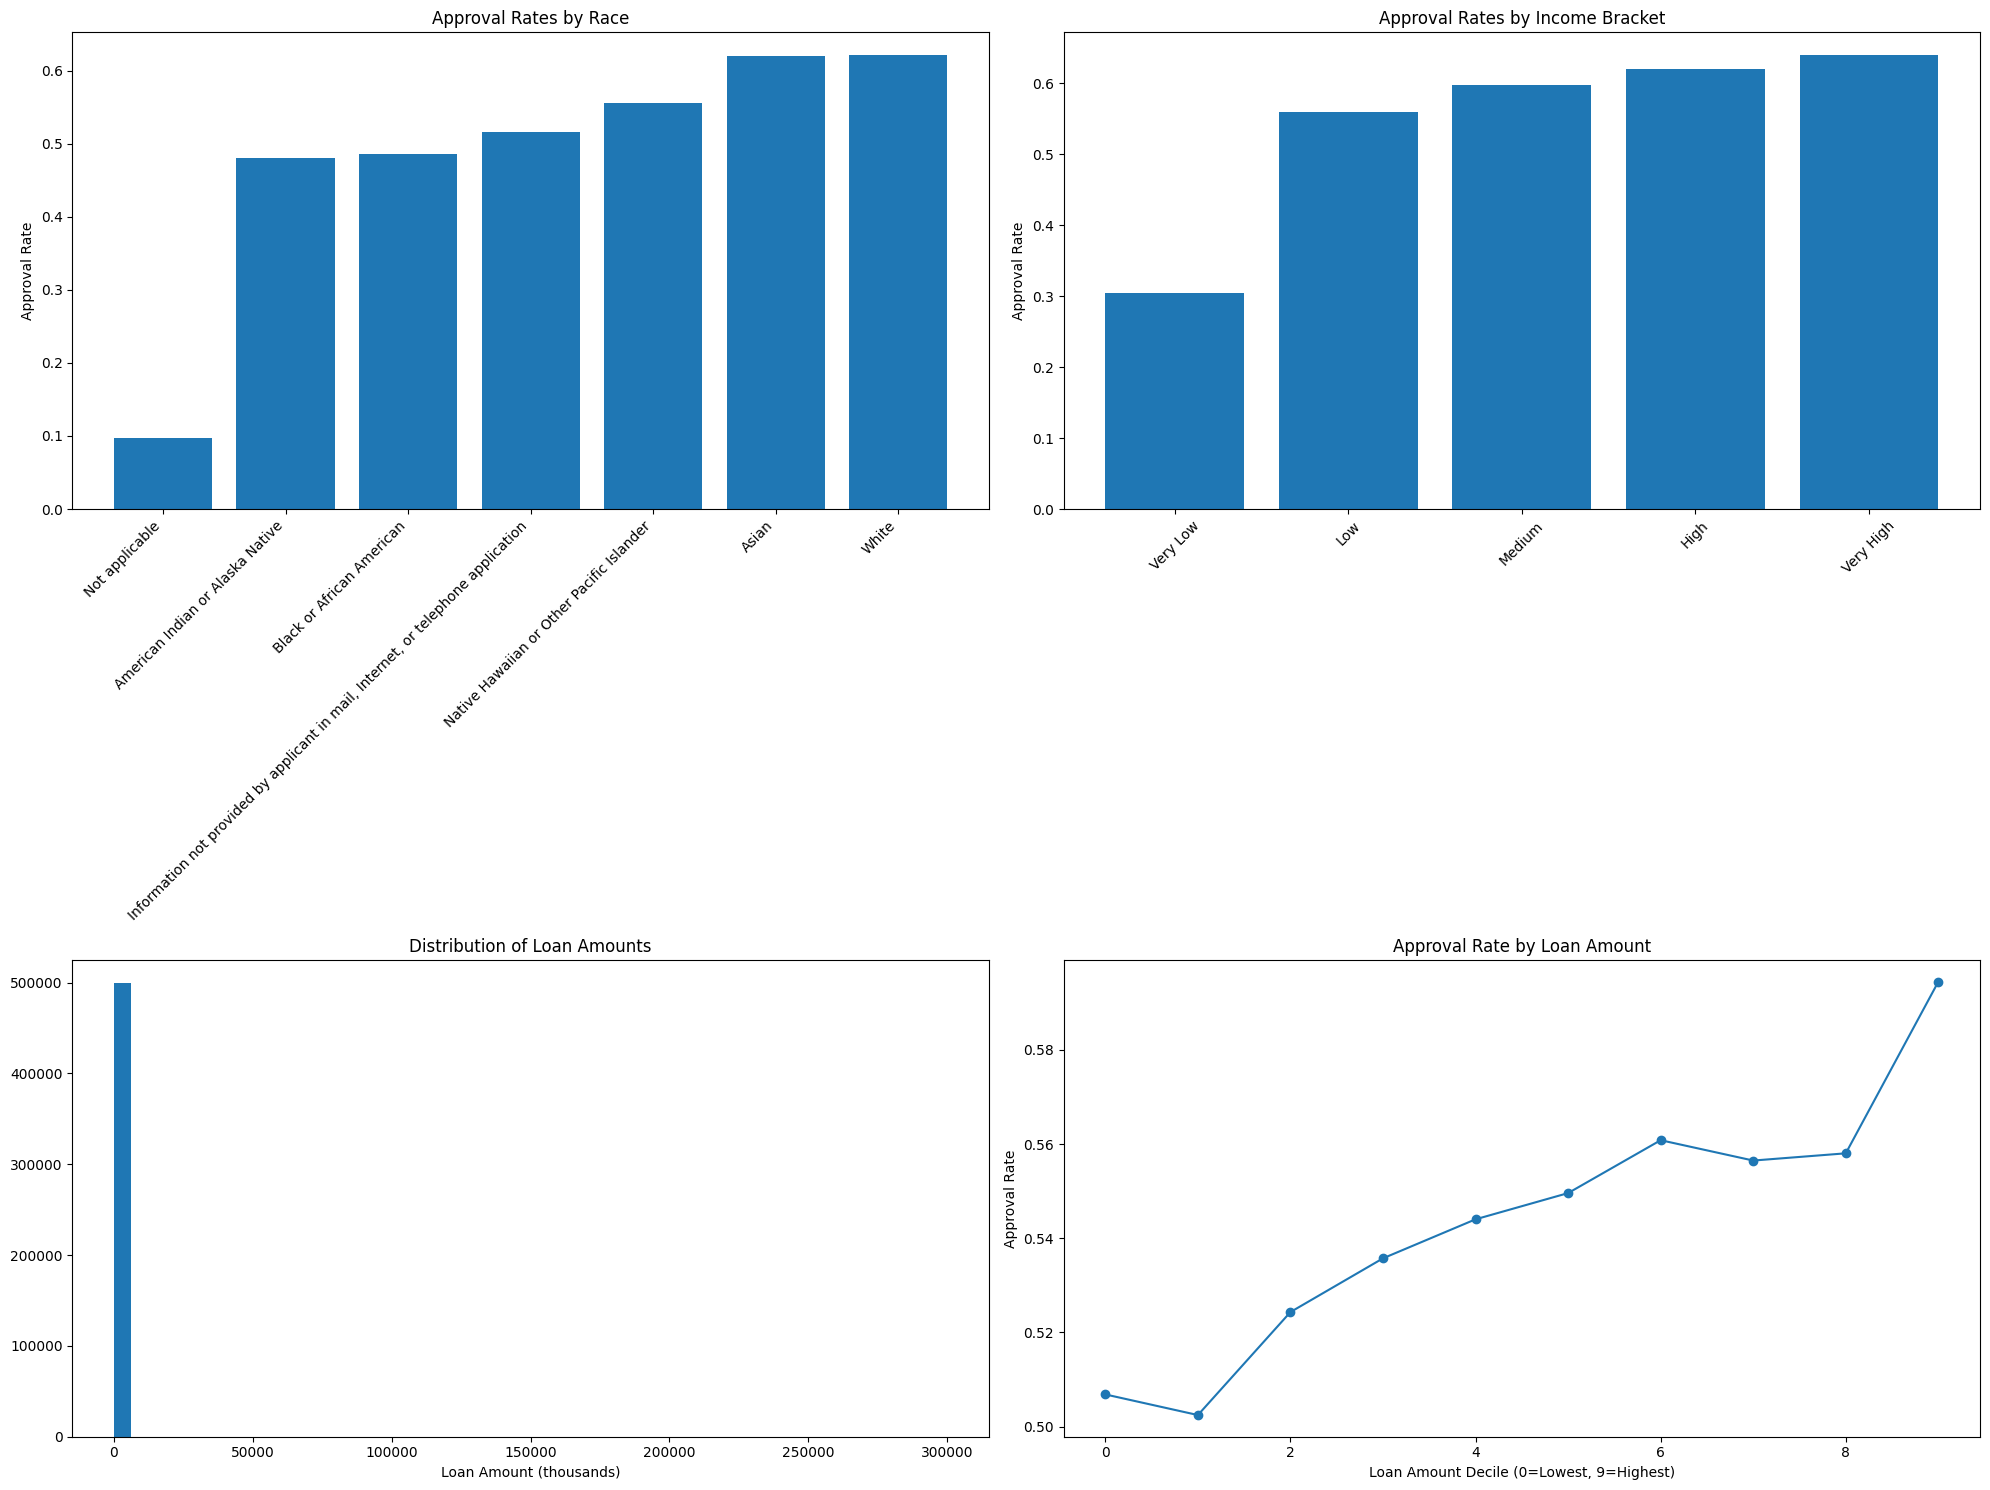


Step 2: Preprocessing data...
Starting data preprocessing...
Handling missing values...
Creating derived features...
Creating model datasets...

Created datasets with shapes:
baseline:
  Training: (273582, 6)
  Testing:  (68396, 6)
with_location:
  Training: (273582, 9)
  Testing:  (68396, 9)
all_features:
  Training: (273582, 12)
  Testing:  (68396, 12)

Preparing scalers...

Feature groups:

baseline features:
  - loan_amount_000s
  - applicant_income_000s
  - hud_median_family_income
  - tract_to_msamd_income
  - income_to_loan_ratio
  - area_income_ratio

location features:
  - state_code
  - county_code
  - minority_population

sensitive features:
  - applicant_race_name_1
  - applicant_ethnicity
  - applicant_sex

Step 3: Training traditional models...
Training models...
Training Random Forest on baseline dataset...
Training Logistic Regression on baseline dataset...
Training XGBoost on baseline dataset...
Training Random Forest on with_location dataset...
Training Logistic Regr

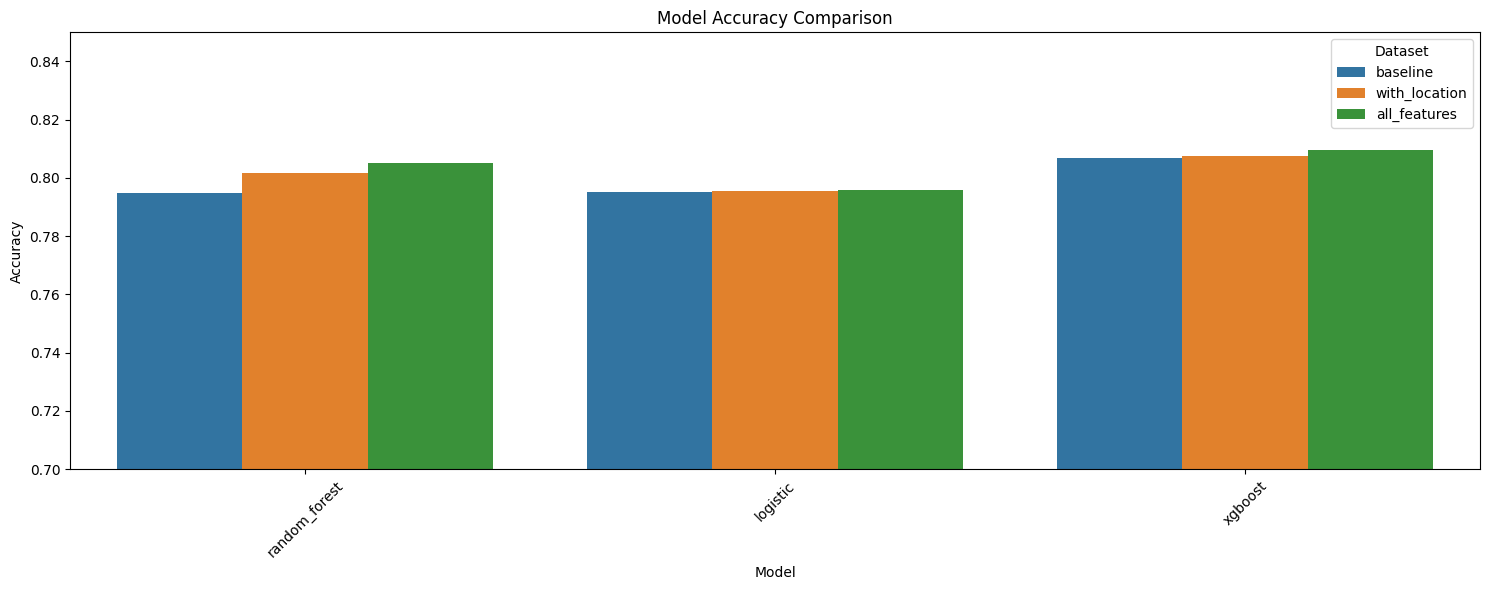

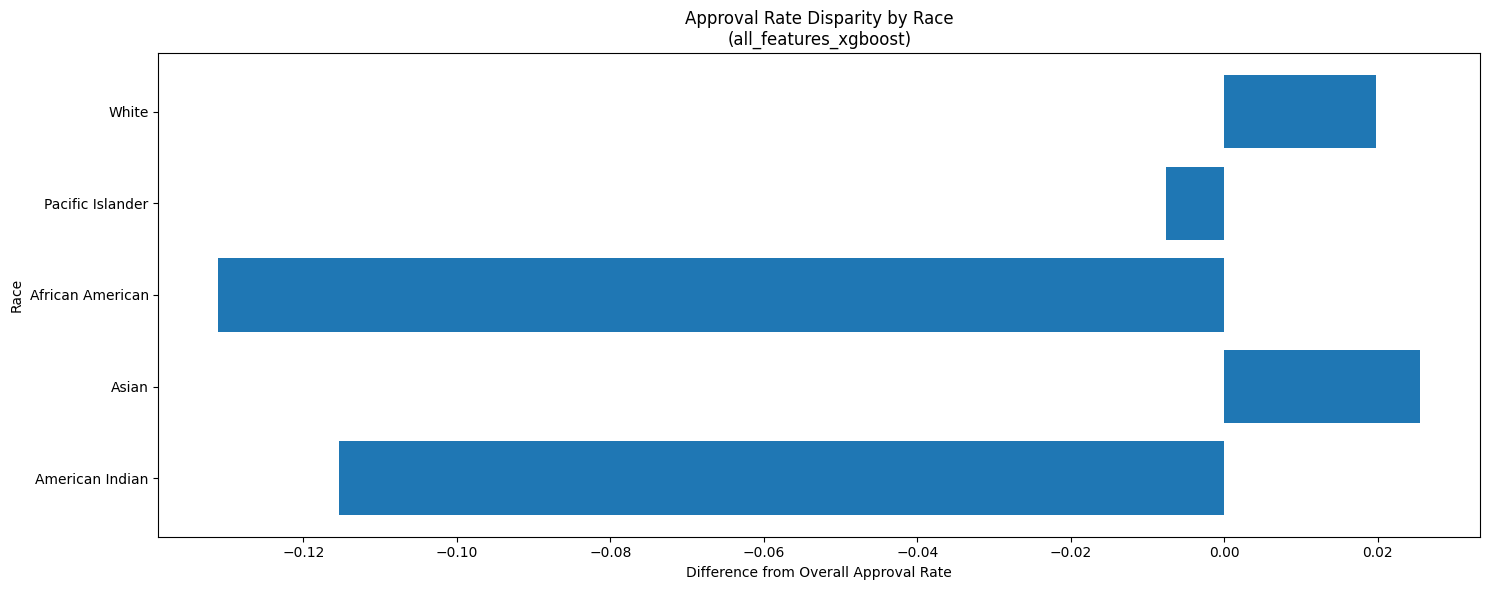


Analyzing feature importance...


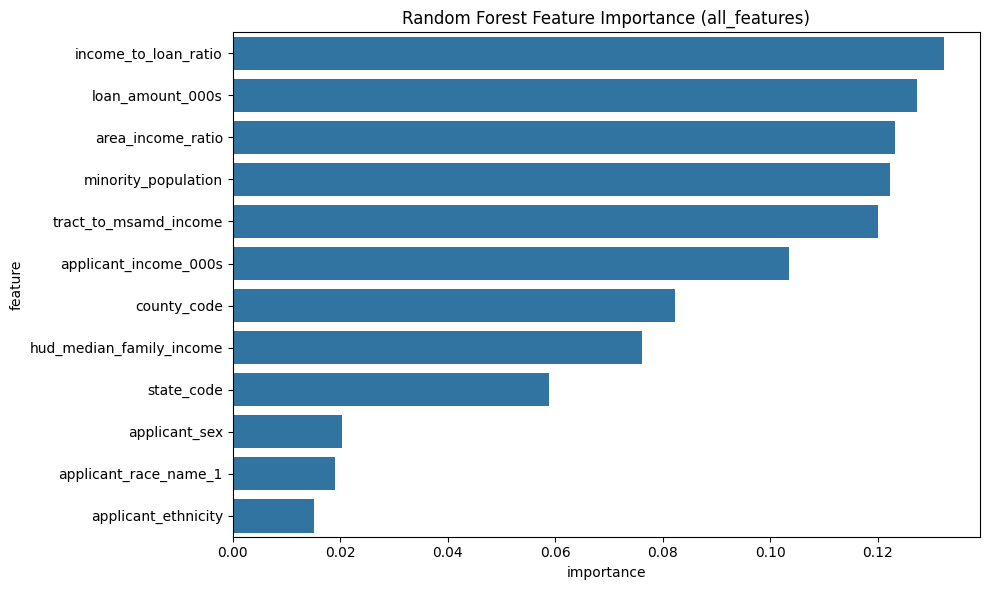

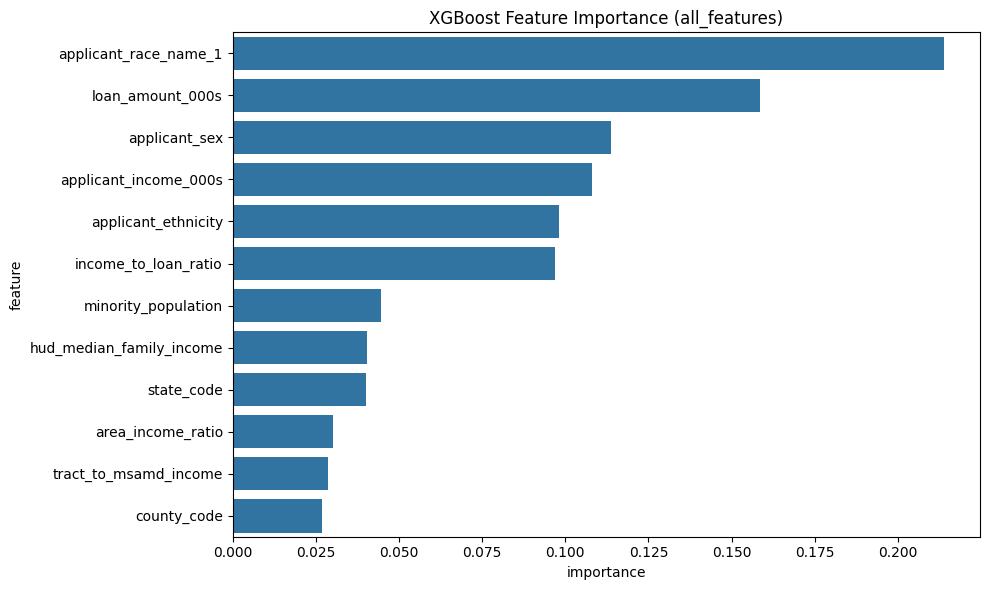


Detailed Bias Analysis:

Model: baseline_random_forest

Racial Bias Analysis:
                               applicant_race_name_1  approved  disparity
0                   American Indian or Alaska Native  0.875211  -0.055852
1                                              Asian  0.954975   0.023912
2                          Black or African American  0.872745  -0.058318
3  Information not provided by applicant in mail,...  0.927672  -0.003391
4          Native Hawaiian or Other Pacific Islander  0.939286   0.008222
5                                     Not applicable  0.970163   0.039100
6                                              White  0.935805   0.004742

Model: baseline_logistic

Racial Bias Analysis:
                               applicant_race_name_1  approved  disparity
0                   American Indian or Alaska Native  0.989882  -0.005074
1                                              Asian  0.999166   0.004210
2                          Black or African American  0.98

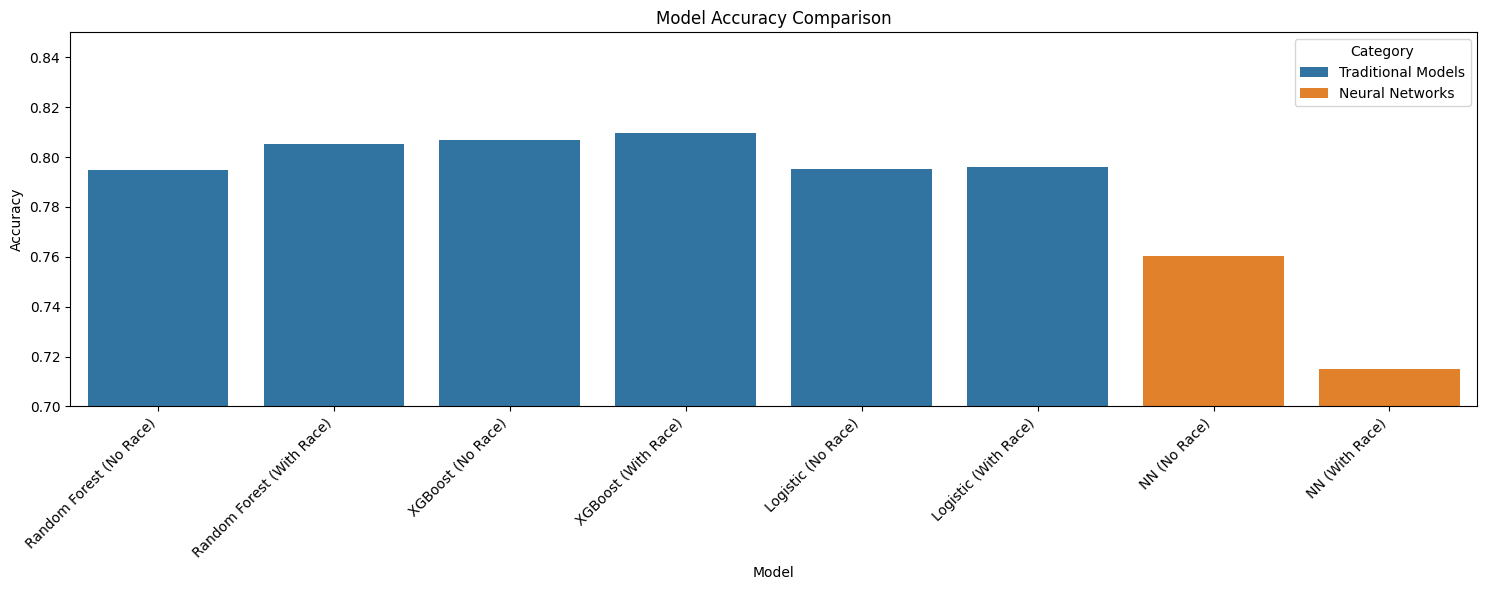

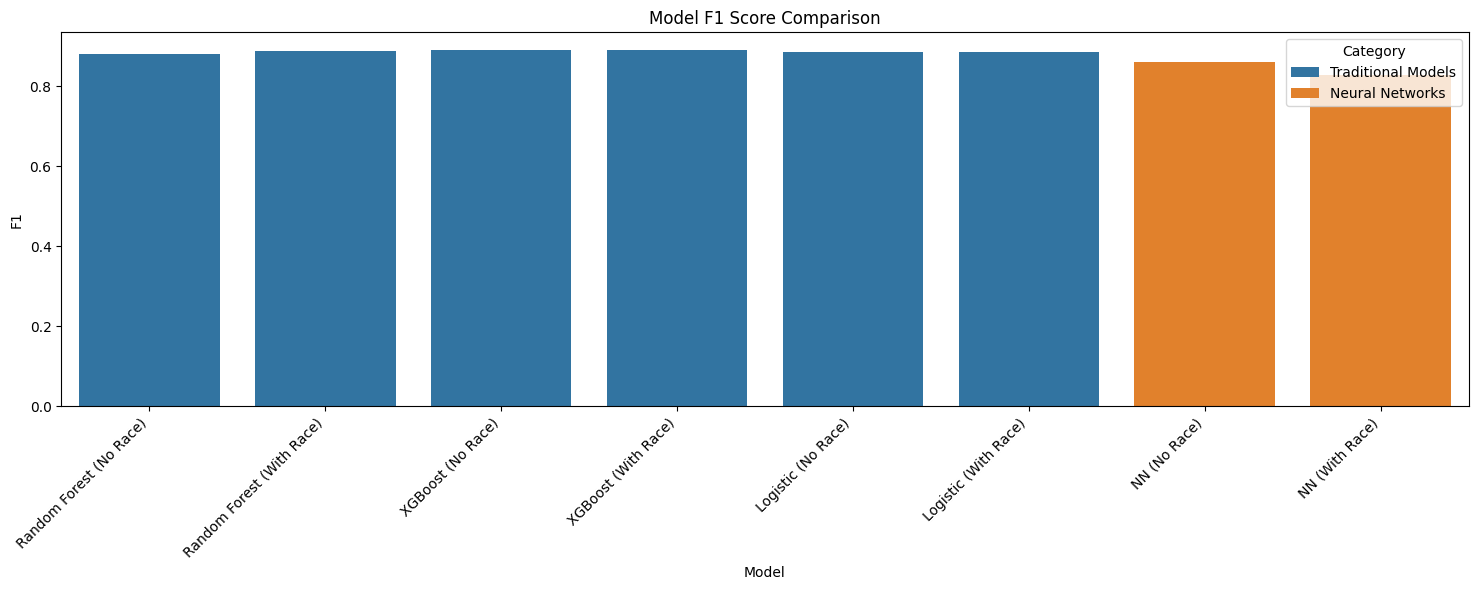


Detailed Model Comparison:
             Category                      Model  Accuracy  Precision    Recall        F1
0  Traditional Models    Random Forest (No Race)  0.794959   0.816350  0.957121  0.881149
1  Traditional Models  Random Forest (With Race)  0.805032   0.819607  0.967412  0.887397
2  Traditional Models          XGBoost (No Race)  0.806992   0.815398  0.978477  0.889525
3  Traditional Models        XGBoost (With Race)  0.809477   0.819922  0.974003  0.890346
4  Traditional Models         Logistic (No Race)  0.795193   0.796153  0.997496  0.885524
5  Traditional Models       Logistic (With Race)  0.795894   0.796846  0.997220  0.885843
6     Neural Networks               NN (No Race)  0.760293   0.794172  0.942392  0.861957
7     Neural Networks             NN (With Race)  0.714983   0.793893  0.865893  0.828331

Impact of Race Feature:

Traditional Models - Random Forest:
Prediction changes when adding race: 5.53%

Traditional Models - XGBoost:
Prediction changes when ad

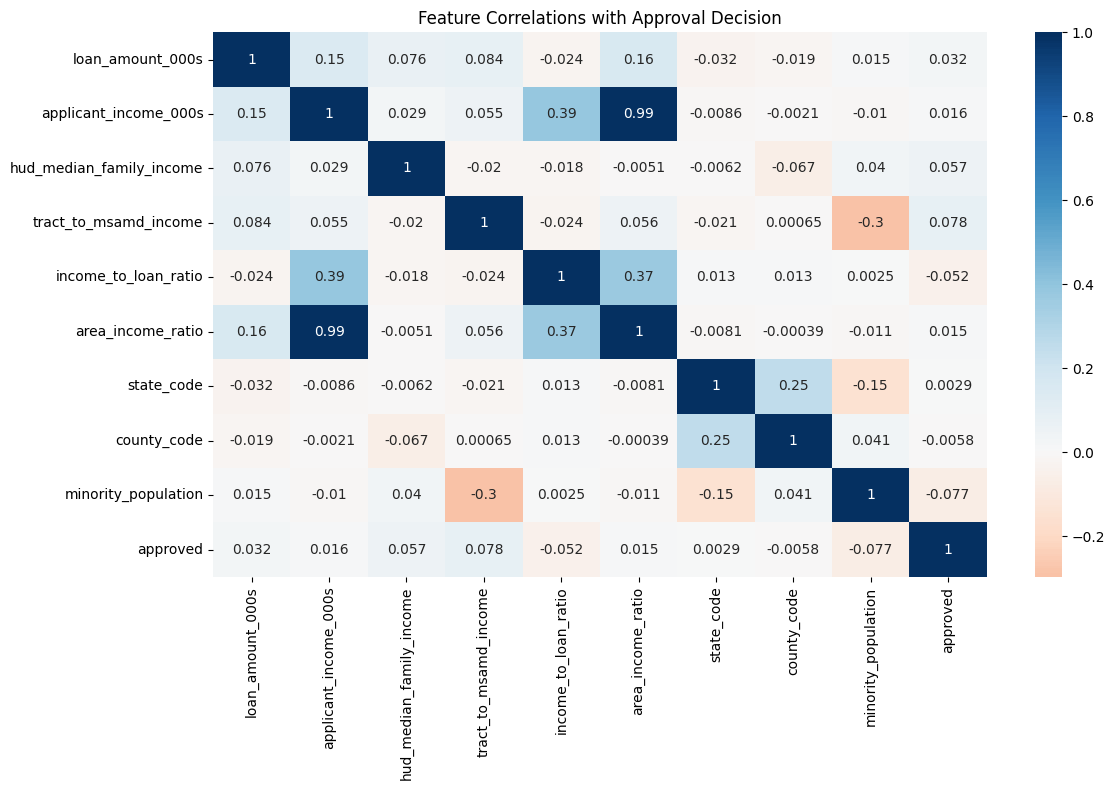

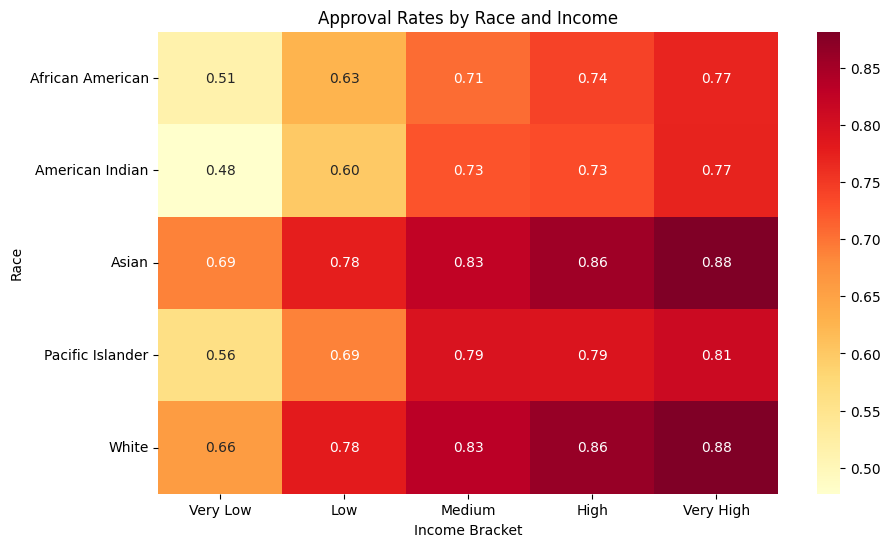

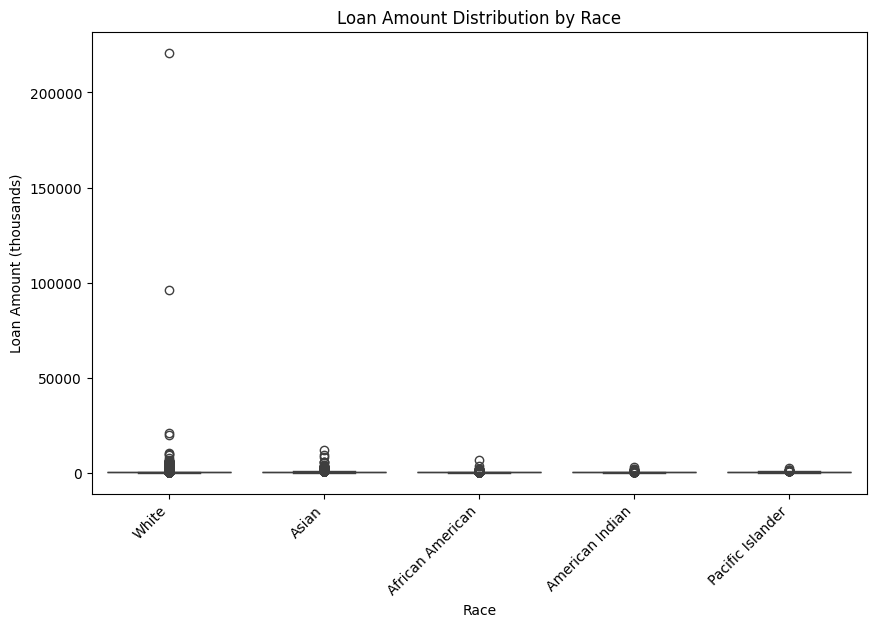


Analyzing sequential feature addition...

Analyzing sequential feature addition...

Testing feature combination: applicant_race_name_1
Training random_forest...
Training logistic...
Training xgboost...

Testing feature combination: applicant_sex
Training random_forest...
Training logistic...
Training xgboost...

Testing feature combination: applicant_ethnicity
Training random_forest...
Training logistic...
Training xgboost...

Testing feature combination: applicant_race_name_1, applicant_sex
Training random_forest...
Training logistic...
Training xgboost...

Testing feature combination: applicant_race_name_1, applicant_ethnicity
Training random_forest...
Training logistic...
Training xgboost...

Testing feature combination: applicant_sex, applicant_ethnicity
Training random_forest...
Training logistic...
Training xgboost...

Testing feature combination: applicant_race_name_1, applicant_sex, applicant_ethnicity
Training random_forest...
Training logistic...
Training xgboost...


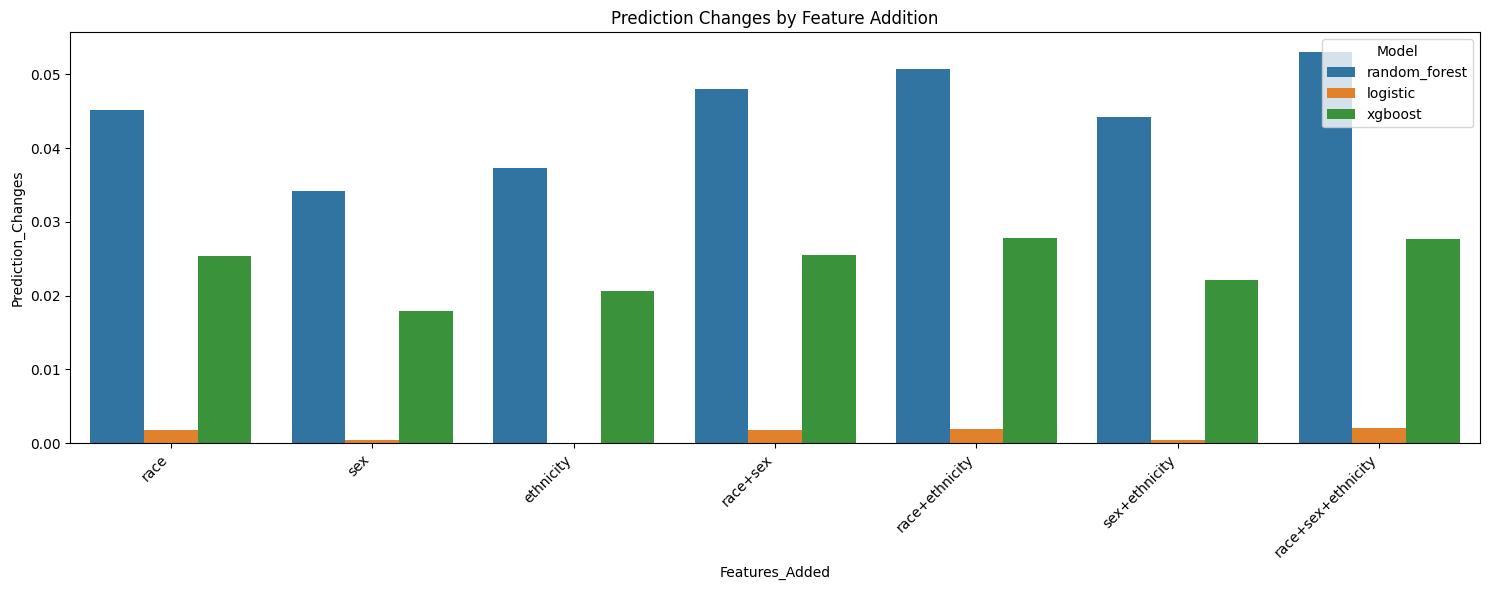

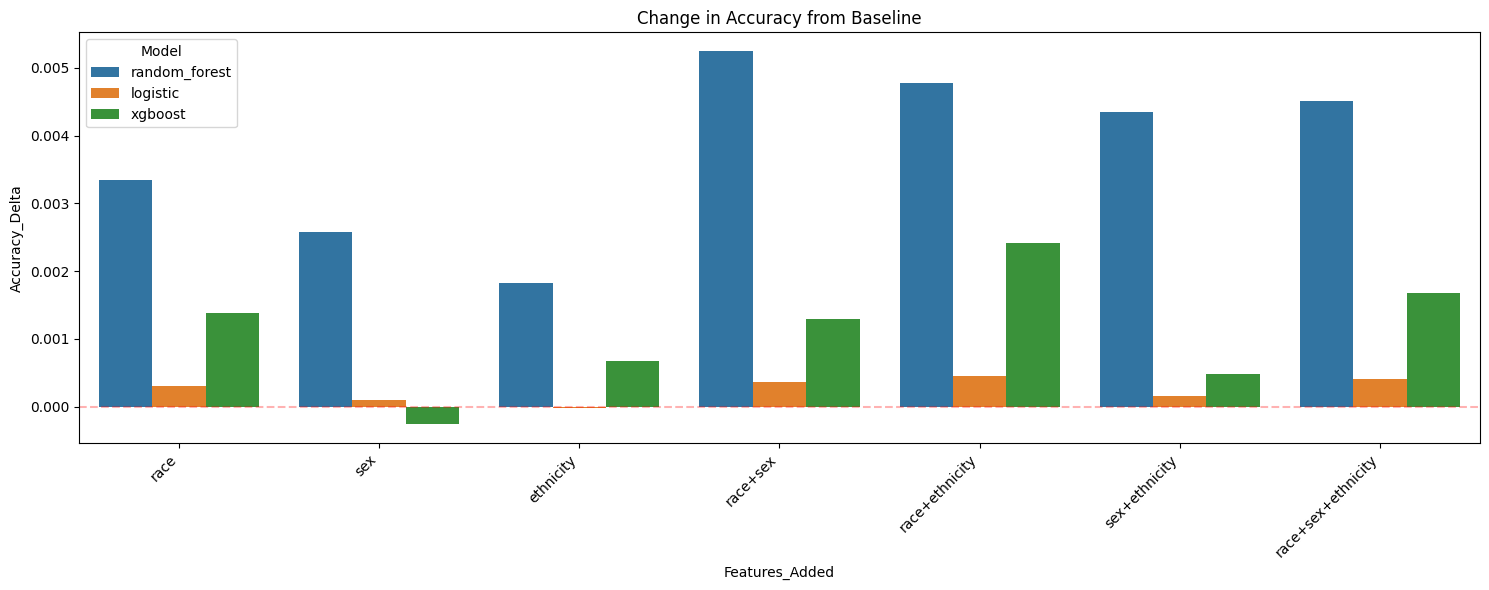


Detailed Results:
            Model      Features_Added  Prediction_Changes  Base_Accuracy  Accuracy  Accuracy_Delta
0   random_forest                race            0.045193       0.794959  0.798307        0.003348
1        logistic                race            0.001740       0.795193  0.795500        0.000307
2         xgboost                race            0.025308       0.806992  0.808381        0.001389
3   random_forest                 sex            0.034154       0.794959  0.797532        0.002573
4        logistic                 sex            0.000424       0.795193  0.795295        0.000102
5         xgboost                 sex            0.017925       0.806992  0.806728       -0.000263
6   random_forest           ethnicity            0.037239       0.794959  0.796786        0.001828
7        logistic           ethnicity            0.000044       0.795193  0.795178       -0.000015
8         xgboost           ethnicity            0.020644       0.806992  0.807664        

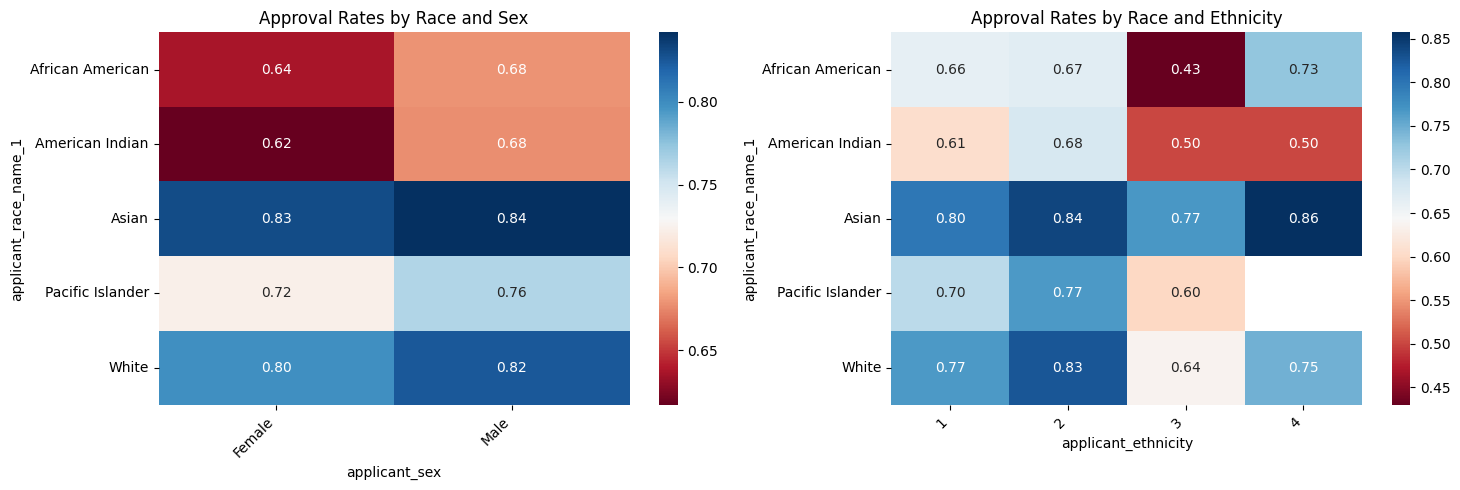


Intersectional Approval Rates (Race and Sex):
applicant_sex          Female   Male
applicant_race_name_1               
African American        0.637  0.678
American Indian         0.617  0.677
Asian                   0.830  0.842
Pacific Islander        0.723  0.763
White                   0.798  0.825

Intersectional Approval Rates (Race and Ethnicity):
applicant_ethnicity        1      2      3      4
applicant_race_name_1                            
African American       0.663  0.668  0.430  0.727
American Indian        0.606  0.679  0.500  0.500
Asian                  0.797  0.840  0.767  0.857
Pacific Islander       0.700  0.766  0.600    NaN
White                  0.766  0.827  0.636  0.746

Analyzing bias amplification...

Comparing ML models with historical decisions...


<Figure size 1500x600 with 0 Axes>

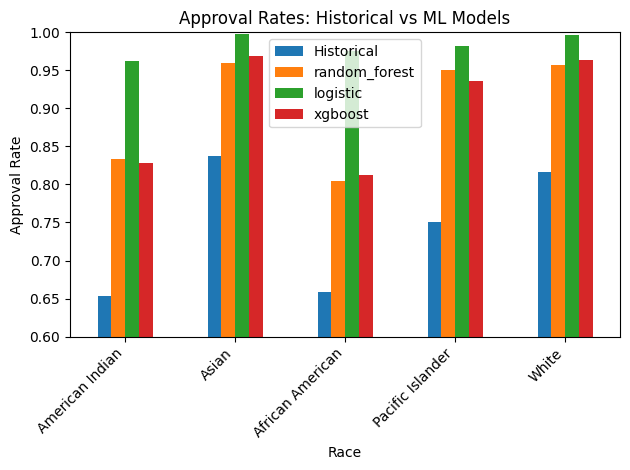

<Figure size 1500x600 with 0 Axes>

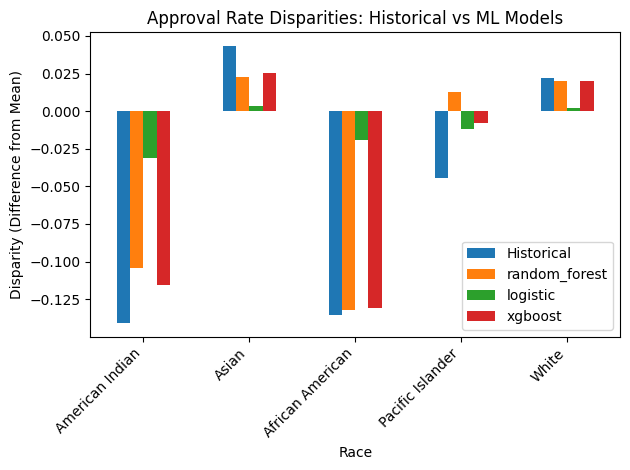


Detailed Approval Rates:
                       Historical  random_forest  logistic  xgboost
applicant_race_name_1                                              
American Indian             0.654          0.833     0.963    0.828
Asian                       0.838          0.960     0.997    0.969
African American            0.659          0.805     0.975    0.812
Pacific Islander            0.750          0.950     0.982    0.936
White                       0.817          0.958     0.996    0.963

Detailed Disparities:
                       Historical  random_forest  logistic  xgboost
applicant_race_name_1                                              
American Indian            -0.141         -0.104    -0.031   -0.115
Asian                       0.043          0.023     0.003    0.026
African American           -0.136         -0.132    -0.019   -0.131
Pacific Islander           -0.044          0.013    -0.012   -0.008
White                       0.022          0.020     0.002    0.020

In [115]:
if __name__ == "__main__":
    # Step 1: Load and prepare initial data
    print("\nStep 1: Loading and preparing data...")
    main_file = 'HDMA/hmda_2017_nationwide_all-records_labels.csv'
    panel_file = 'HDMA/hmda_2017_panel.csv'
    ts_file = 'HDMA/hmda_2017_transmittal_sheet.csv'
    
    df, stats = load_and_prepare_data(main_file, panel_file, ts_file)
    
    # Generate initial visualizations
    print("\nGenerating initial visualizations...")
    generate_exploratory_plots(df, stats)
    
    # Step 2: Preprocess and create datasets
    print("\nStep 2: Preprocessing data...")
    data, feature_groups = preprocess_data(df)
    datasets = create_model_datasets(data, feature_groups)
    scalers = prepare_scalers(datasets)

    # Print feature group information
    print("\nFeature groups:")
    for group, features in feature_groups.items():
        print(f"\n{group} features:")
        for feature in features:
            print(f"  - {feature}")
    
    # Clear some memory
    del df
    
    # Step 3: Train traditional models
    print("\nStep 3: Training traditional models...")
    models = train_models(datasets, scalers)
    
    # Step 4: Evaluate traditional models
    print("\nStep 4: Evaluating traditional models...")
    evaluation_results = evaluate_models(models, datasets)
    print("\nModel Evaluation Results:")
    print(evaluation_results)

    print("\nAnalyzing bias and fairness, as well as feature importance...")
    bias_metrics = analyze_bias(models, data, datasets)
    plot_results(evaluation_results, bias_metrics)
    analyze_feature_importance(models)

    # Print detailed bias analysis
    print("\nDetailed Bias Analysis:")
    for model_key, metrics in bias_metrics.items():
        print(f"\nModel: {model_key}")
        print("\nRacial Bias Analysis:")
        print(metrics['race_bias'])
    
    # Step 5: Load neural network predictions
    print("\nStep 5: Loading neural network predictions...")
    nn_preds_no_race, nn_preds_with_race = load_nn_predictions()
    
    # Step 6: Compare all models
    print("\nStep 6: Comparing all models...")
    compare_all_models(models, nn_preds_no_race, nn_preds_with_race, data, datasets)
    
    # Step 7: Additional analysis
    print("\nStep 7: Performing additional analysis...")
    prediction_changes = analyze_prediction_changes(models, data, datasets)
    fairness_metrics = calculate_fair_metrics(models, data, datasets)
    
    print("\nPrediction Changes Analysis:")
    print(prediction_changes)
    print("\nFairness Metrics:")
    print(fairness_metrics)
    
    # Generate final visualizations
    print("\nGenerating final visualizations...")
    analyze_feature_correlations(data, feature_groups)
    plot_demographic_distribution(data)

    # Run sequential feature analysis
    print("\nAnalyzing sequential feature addition...")
    analyze_sequential_feature_addition(data, models, scalers, feature_groups, datasets)
    
    # Run intersectional bias analysis
    print("\nAnalyzing intersectional bias...")
    analyze_intersectional_bias(data)

    print("\nAnalyzing bias amplification...")
    compare_human_ml_bias(data, models, datasets)
    
    print("\nAnalysis complete!")